In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 123
BATCH_SIZE = 64
NUM_EPOCHS = 15

# Architecture
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"
GRAYSCALE = False

Cifar10 - Dataset

In [ ]:
import sys
# sys.path.insert(0, "/content/helper") # to include ../helper_evaluate.py etc.
sys.path.insert(0, "/content/helper")
# From local helper files
from helper_utils import set_all_seeds, set_deterministic
from helper_evaluate import compute_confusion_matrix, compute_accuracy
from helper_train import train_classifier_simple_v2,train_classifier_simple_v2_weighted
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_data import get_dataloaders_cifar10, UnNormalize

In [ ]:
# Data augmentation (aligned with MobileNetV2)
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# DataLoader (aligned with MobileNetV2)
train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    num_workers=2,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    validation_fraction=0.1
)

Files already downloaded and verified


In [ ]:
import torchvision.models as models

torch.manual_seed(RANDOM_SEED)

# Load pre-trained DenseNet and replace the classifier
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 10)  # CIFAR-10 has 10 classes

model = model.to(DEVICE)  # Ensure the model is on the correct device

# Set up the optimizer, using a smaller learning rate might be preferable for fine-tuning
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adjusted learning rate for fine-tuning


Training

In [ ]:
def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    model.eval()
    for i, (features, targets) in enumerate(data_loader):
        features = features.to(device)
        targets = targets.to(device)

        logits = model(features)  # Directly use logits output
        _, predicted_labels = torch.max(logits, 1)  # Apply torch.max on logits
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float() / num_examples * 100


In [ ]:
import torch.nn.functional as F

class_weights = torch.tensor([2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0], device=DEVICE)
weighted_loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)

start_time = time.time()
cost_list = []
train_acc_list, valid_acc_list = [], []


for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits= model(features)
        cost = weighted_loss_function(logits, targets)  # Using weighted loss function
        optimizer.zero_grad()
        cost.backward()
        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        #################################################
        ### CODE ONLY FOR LOGGING BEYOND THIS POINT
        ################################################
        cost_list.append(cost.item())
        if not batch_idx % 150:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |'
                   f' Cost: {cost:.4f}')



    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference

        train_acc = compute_acc(model, train_loader, device=DEVICE)
        valid_acc = compute_acc(model, valid_loader, device=DEVICE)

        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_acc:.2f} | Validation ACC: {valid_acc:.2f}')

        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)

    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/015 | Batch 000/703 | Cost: 2.4749
Epoch: 001/015 | Batch 150/703 | Cost: 0.7092
Epoch: 001/015 | Batch 300/703 | Cost: 0.3526
Epoch: 001/015 | Batch 450/703 | Cost: 0.5009
Epoch: 001/015 | Batch 600/703 | Cost: 0.3853
Epoch: 001/015
Train ACC: 87.18 | Validation ACC: 85.68
Time elapsed: 10.17 min
Epoch: 002/015 | Batch 000/703 | Cost: 0.3306
Epoch: 002/015 | Batch 150/703 | Cost: 0.2003
Epoch: 002/015 | Batch 300/703 | Cost: 0.4569
Epoch: 002/015 | Batch 450/703 | Cost: 0.4133
Epoch: 002/015 | Batch 600/703 | Cost: 0.2751
Epoch: 002/015
Train ACC: 91.91 | Validation ACC: 89.30
Time elapsed: 20.30 min
Epoch: 003/015 | Batch 000/703 | Cost: 0.1592
Epoch: 003/015 | Batch 150/703 | Cost: 0.2491
Epoch: 003/015 | Batch 300/703 | Cost: 0.1904
Epoch: 003/015 | Batch 450/703 | Cost: 0.2335
Epoch: 003/015 | Batch 600/703 | Cost: 0.4518
Epoch: 003/015
Train ACC: 94.36 | Validation ACC: 91.00
Time elapsed: 30.42 min
Epoch: 004/015 | Batch 000/703 | Cost: 0.1400
Epoch: 004/015 | Batch 1

Evaluation

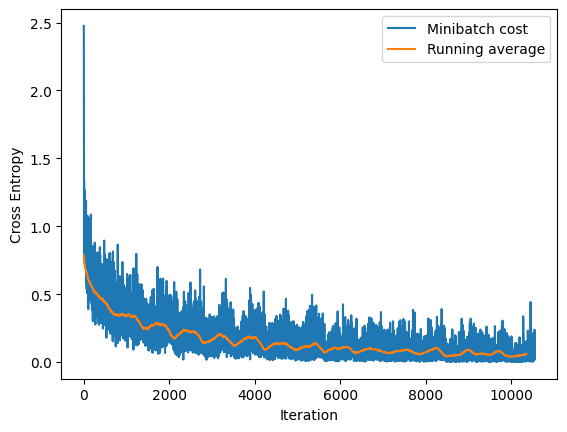

In [ ]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list,
                     np.ones(200,)/200, mode='valid'),
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

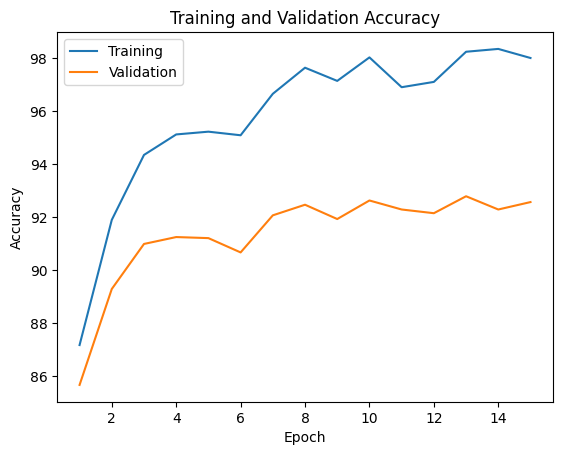

In [ ]:
plt.plot(np.arange(1, NUM_EPOCHS+1), [acc.cpu().numpy() for acc in train_acc_list], label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), [acc.cpu().numpy() for acc in valid_acc_list], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [ ]:
with torch.set_grad_enabled(False):
    train_acc = compute_acc(model=model,
                            data_loader=train_loader,
                            device=DEVICE)

    valid_acc = compute_acc(model=model,
                            data_loader=valid_loader,
                            device=DEVICE)

    test_acc = compute_acc(model=model,
                           data_loader=test_loader,
                           device=DEVICE)

print(f'Training ACC: {train_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Training ACC: 98.02%
Validation ACC: 92.58%
Test ACC: 92.34%


In [ ]:
from sklearn.metrics import f1_score

def compute_f1_score(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)  # Directly getting logits
            _, predicted_labels = torch.max(logits, 1)  # Applying softmax is not necessary for finding the max
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted_labels.cpu().numpy())

    return f1_score(y_true, y_pred, average='macro')  # or 'micro', 'weighted', 'binary'

train_f1_score = compute_f1_score(model, train_loader, device=DEVICE)
valid_f1_score = compute_f1_score(model, valid_loader, device=DEVICE)
test_f1_score = compute_f1_score(model, test_loader, device=DEVICE)

print(f"Overall F1-score on train set: {train_f1_score:.4f}")
print(f"Overall F1-score on valid set: {valid_f1_score:.4f}")
print(f"Overall F1-score on test set: {test_f1_score:.4f}")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Overall F1-score on train set: 0.9802
Overall F1-score on valid set: 0.9261
Overall F1-score on test set: 0.9235


In [ ]:
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

# Move the model back to CPU for evaluation to avoid GPU memory issues
device = torch.device('cpu')
model.to(device)

# Initialize lists to store true and predicted labels
y_true_list = []
y_pred_list = []

# Iterate over the test dataset to obtain true and predicted labels
for features, targets in test_loader:
    features = features.to(device)
    targets = targets.to(device)

    # Forward pass to get predicted labels
    logits = model(features)
    _, predicted = torch.max(logits, 1)

    # Append true and predicted labels to the lists
    y_true_list.extend(targets.numpy())  # No need for CPU transfer
    y_pred_list.extend(predicted.numpy())

# Compute precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(np.array(y_true_list), np.array(y_pred_list), average=None)

# Plot the results
classes = list(class_dict.values())  # Ensure you have this from your data preparation phase
metrics = {'Precision': precision, 'Recall': recall, 'F1-Score': f1}
colors = plt.cm.get_cmap('tab10', len(classes))

for metric_name, metric_values in metrics.items():
    plt.figure(figsize=(14, 6))
    bars = plt.bar(classes, metric_values, color=colors(np.arange(len(classes))))
    plt.title(f'{metric_name} for Each Class')
    plt.xlabel('Classes')
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for bar, value in zip(bars, metric_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()


NameError: name 'torch' is not defined

In [ ]:
save_path = '/content/drive/MyDrive/tempFolder/1.0/(yy.xx.%)denseNet.pth'
torch.save(model.state_dict(), save_path)